# L01 - Data exploration and analysis

## 1. Import libraries

In [56]:
import numpy as np
import os
import gdown
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import cv2
import random
# import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]

# 2. Download data

In [2]:
def downloader(From = "https://drive.google.com/open?id=18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg",
               To = "/home/kia/Desktop/PoD/NNDL/data/"):

    """
    Downloads a folder from Google Drive to a specified local directory.

    Parameters
    ----------
    From : str, optional
        URL of the Google Drive folder to download. Default is a sample folder URL.
    To : str, optional
        Path to the local directory where the folder will be downloaded. Default is 
        '/home/kia/Desktop/PoD/NNDL/data/'.

    Returns
    -------
    None
        Downloads the folder to the specified location.
    """


    # Folder link and destination directory
    folder_url = From
    destination = To

    # Create destination directory if it doesn't exist
    os.makedirs(destination, exist_ok=True)

    # Download folder recursively
    gdown.download_folder(folder_url, quiet=False, output=destination)

In [3]:
def combine_zips(input_zip, output_zip, directory="/home/kia/Desktop/PoD/NNDL/data/"):
    
    """
    Combines split zip files using the `zip -F` command.

    Parameters
    ----------
    input_zip : str
        Path to the main split zip file (e.g., `data.zip`).
    output_zip : str
        Path for the combined output zip file.
    directory : str, optional
        Path to the directory containing the split zip parts. If None, assumes the current directory.

    Returns
    -------
    None
    """

    
    command = ["zip", "-F", input_zip, "--out", output_zip]
    
    if directory:
        command = ["cd", directory, "&&"] + command  
    
    try:
        subprocess.run(" ".join(command), shell=True, check=True)
        print(f"Combined ZIP file saved as {output_zip}")
    except subprocess.CalledProcessError as e:
        print(f"Error combining ZIP files: {e}")


In [4]:
def unzip_file(zip_file, password, directory):

    """
    Extracts a ZIP file using a password in quiet mode.

    Parameters
    ----------
    zip_file : str
        Path to the ZIP file.
    password : str
        Password for the ZIP file.
    directory : str
        Directory to extract the files to and from.

    Raises
    ------
    subprocess.CalledProcessError
        If the `unzip` command fails.
    """
    
    zip_file = os.path.join(directory, zip_file)
    try:
        command = [
            "unzip", "-q", "-P", password, zip_file, "-d", directory
        ]
        
        subprocess.run(command, check=True)
        print(f"Successfully unzipped {zip_file} to {directory}")
    
    except subprocess.CalledProcessError as e:
        print(f"Error during unzip: {e}")



## 2.1 Download, Combine and Unzip dataset

In [5]:
# Define working directory.
ROOT_DIR = os.getcwd()
DATA_FOLDER = "data"

try:
    os.listdir(os.path.join(ROOT_DIR, DATA_FOLDER))
    print("Data folder exists.")
except:
    os.mkdir(os.path.join(ROOT_DIR, DATA_FOLDER))

try:
    os.listdir(os.path.join(ROOT_DIR, DATA_FOLDER, "CompCars"))
    print("CompCars folder exists.")

except:
    print("Downloading dataset...")
    downloader(To = os.path.join(ROOT_DIR, DATA_FOLDER))
    print("Download complete.")
    print("Merging files...")
    combine_zips("sv_data.zip", "sv_combined.zip", os.path.join(ROOT_DIR, DATA_FOLDER, "CompCars"))
    print("Merging complete.")
    print("Unzipping files...")
    unzip_file("sv_combined.zip", "d89551fd190e38", os.path.join(ROOT_DIR, DATA_FOLDER, "CompCars"))
    print("Unzipping complete.")

Data folder exists.
CompCars folder exists.


In [6]:
# shuffle, split

# def prepare_labels():

VerTr = pd.read_csv(os.path.join(SPLITS_DIR, "verification_train.txt"), sep="/", header=None, names=["make", "model","year", "fname"]).drop("year", axis=1)
# TestE = pd.read_csv(os.path.join(SPLITS_DIR, "verification_pairs_easy.txt"), sep=r'[/ ]', header=None, engine="python", names=["make1", "mod1","y1", "fname1", "make2", "mod2", "y2", "fname2", "lab"])#.drop("y1", "y2", axis=1)

NameError: name 'SPLITS_DIR' is not defined

In [7]:
# my_dir = "/home/kia/Desktop/PoD/NNDL/Data/"

# downloader(To = my_dir)

# combine_zips("data.zip", "combined.zip", my_dir)

# unzip_file(my_dir+"combined.zip", "d89551fd190e38", my_dir+"combined")

In [8]:
%%bash

cd data/CompCars/data/train_test_split/verification/
ls

verification_pairs_easy.txt
verification_pairs_hard.txt
verification_pairs_medium.txt
verification_train.txt


### overview

In [9]:
view_dict = {-1:"uncertain", 1:"front", 2:"rear", 3:"side", 4:"front-side", 5:"rear-side"}

LAB_DIR = os.path.join(ROOT_DIR, "data/CompCars/data/label/")
IMG_DIR = os.path.join(ROOT_DIR, "data/CompCars/data/image/")
SPLITS_DIR = os.path.join(ROOT_DIR, "data/CompCars/data/train_test_split/verification/")

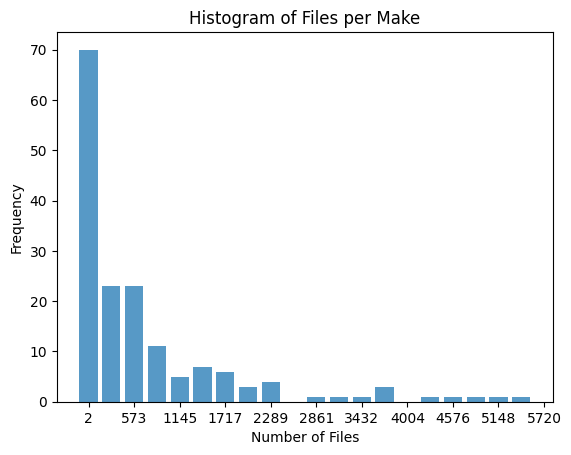

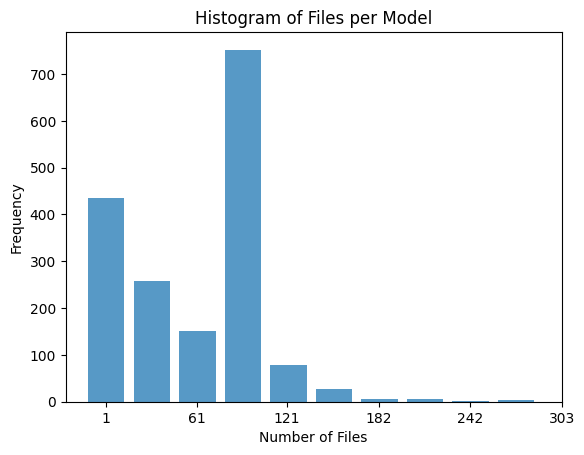

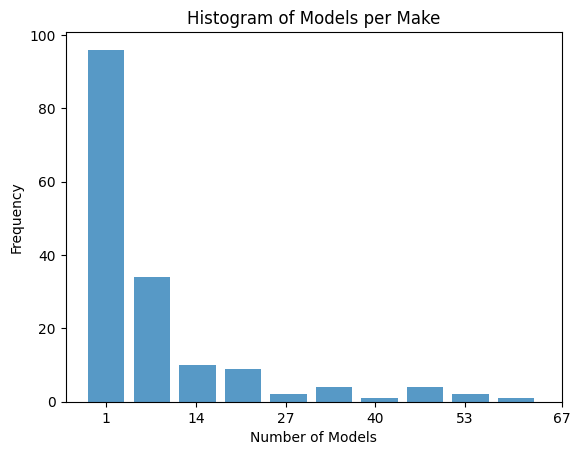

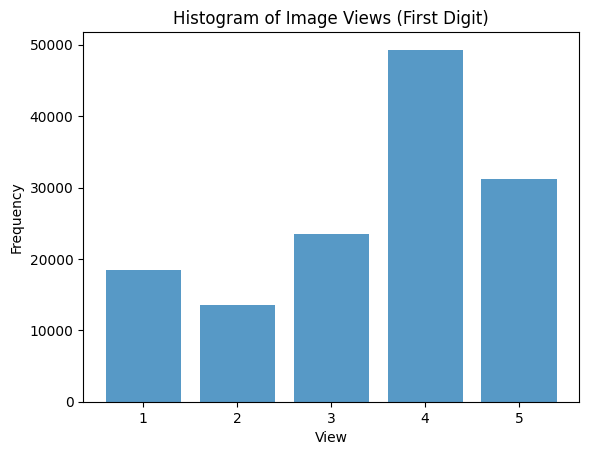

Number of files: 135946


In [10]:
# Initialize data structures to hold counts
files_per_make = defaultdict(int)
files_per_model = defaultdict(int)
models_per_make = defaultdict(set)

# Data for histogram
views = []

# Walk through the directory structure

for root, dirs, files in os.walk(LAB_DIR):
    path_parts = root.split(os.sep)
    
    # Identify make and model from the path
    if len(path_parts) >= len(LAB_DIR.split(os.sep))+2:
        make = path_parts[-3]
        model = path_parts[-2]
        
        # Update counts
        files_per_make[make] += len(files)
        files_per_model[model] += len(files)
        models_per_make[make].add(model)
        
        # Read data from description.txt files
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                content = f.read().strip()
                # Extract the first digit (view of the image)
                if content and content[0].isdigit():
                    views.append(int(content[0]))

# Convert sets to counts
models_per_make = {k: len(v) for k, v in models_per_make.items()}

fpmake = files_per_make.values()
plt.hist(fpmake, bins=20,align='left', rwidth=0.8, alpha=0.75)
plt.title('Histogram of Files per Make')
plt.xlabel('Number of Files')
plt.ylabel('Frequency')
plt.xticks(np.linspace(min(fpmake), max(fpmake),11, dtype=int)) 
plt.show()

fpmodel = files_per_model.values()
plt.hist(fpmodel, bins=10,align='left', rwidth=0.8, alpha=0.75)
plt.title('Histogram of Files per Model')
plt.xlabel('Number of Files')
plt.ylabel('Frequency')
plt.xticks(np.linspace(min(fpmodel), max(fpmodel),6, dtype=int))
plt.show()

modpmak = models_per_make.values()
plt.hist(modpmak, bins=10, align='left', rwidth=0.8, alpha=0.75)
plt.title('Histogram of Models per Make')
plt.xlabel('Number of Models')
plt.ylabel('Frequency')
plt.xticks(np.linspace(min(modpmak), max(modpmak),6, dtype=int))
plt.show()

# Plot histogram of views
plt.hist(views, bins=np.arange(6)+1, align='left', rwidth=0.8, alpha=0.75)
plt.title('Histogram of Image Views (First Digit)')
plt.xlabel('View')
plt.ylabel('Frequency')
plt.xticks(np.arange(1,6,1))
plt.show()

print("Number of files:", len(views))


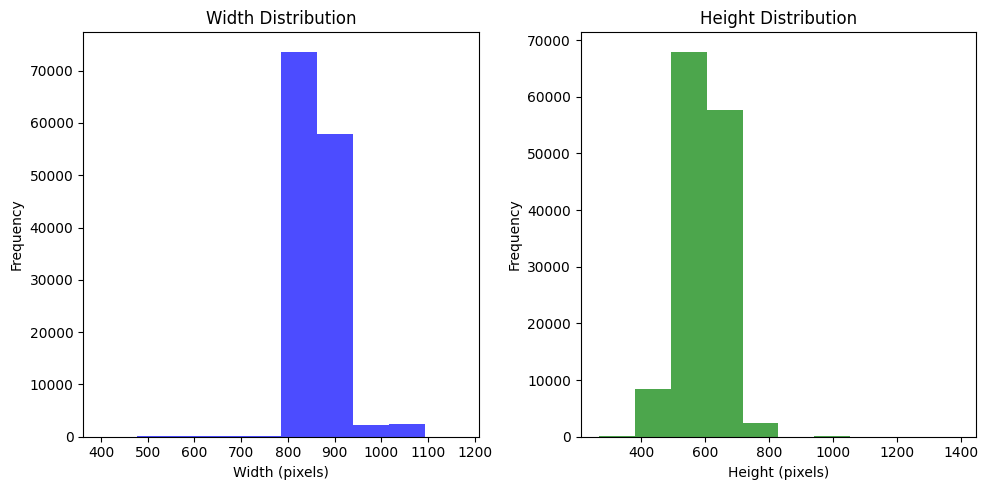

Number of unique resolutions: 485


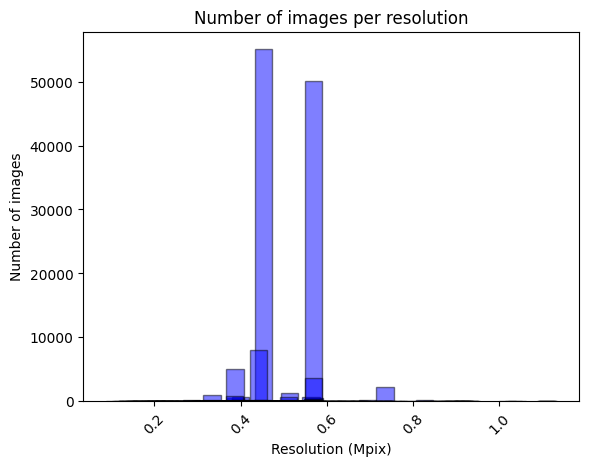

In [11]:
widths = []
heights = []
files_per_resolution = defaultdict(set)

# Traverse the directory
for root, dirs, files in os.walk(IMG_DIR):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            # Open image using PIL
            with Image.open(file_path) as img:
                widths.append(img.width)
                heights.append(img.height)
                files_per_resolution[(img.width, img.height)].add(file)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")


files_per_resolution = {k: len(v) for k, v in files_per_resolution.items()}
# files_per_resolution = {k: len(v) for k, v in files_per_resolution.items()}

# Plot histogram of resolutions
plt.figure(figsize=(10, 5))

# Create width and height histograms
plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='blue', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='green', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print(f"Number of unique resolutions: {len(files_per_resolution)}")
labs = np.array([np.prod(list(files_per_resolution.keys())[i]) for i in range(len(files_per_resolution.keys()))])/1000000
plt.bar(labs,files_per_resolution.values(),width=0.04,color="blue",edgecolor="black",alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel("Resolution (Mpix)")
plt.ylabel("Number of images")
plt.title("Number of images per resolution")
plt.show()



In [32]:
def ResizeAndPad(image, target_size=(256, 256), padding_color=(0, 0, 0), resize=True):
    """
    Pads or resizes an image to a target size while maintaining its aspect ratio.
    
    Args:
        image (numpy.ndarray): Input image (H x W x C).
        target_size (tuple): Target size as (width, height).
        padding_color (tuple): Color of padding (default black) as (B, G, R).
        resize (bool): If True, resizes the image to fit within the target size before padding. 
                       If False, only adds padding to match the target size without resizing.
                       The target size must be greater than or equal to the original size if resizing is False.
    
    Returns:
        numpy.ndarray: Image padded or resized and padded to the target size.
    
    Notes:
        - The `INTER_AREA` interpolation method is used for resizing. It reduces aliasing effects while downsampling by averaging pixel values with respect to the overlapping area of the pixels.
    """
    target_width, target_height = target_size
    original_height, original_width = image.shape[:2]

    if not resize:
        if original_width > target_width or original_height > target_height:
            raise ValueError("Target size must be greater than or equal to the original size when resizing is disabled.")

        new_width, new_height = original_width, original_height
    else:
        # Calculate scaling factor to fit the image within the target size
        scale = min(target_width / original_width, target_height / original_height)
        new_width = max(int(original_width * scale), 1)
        new_height = max(int(original_height * scale), 1)

    if resize:
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    else:
        resized_image = image

    padded_image = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)

    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image

    return padded_image


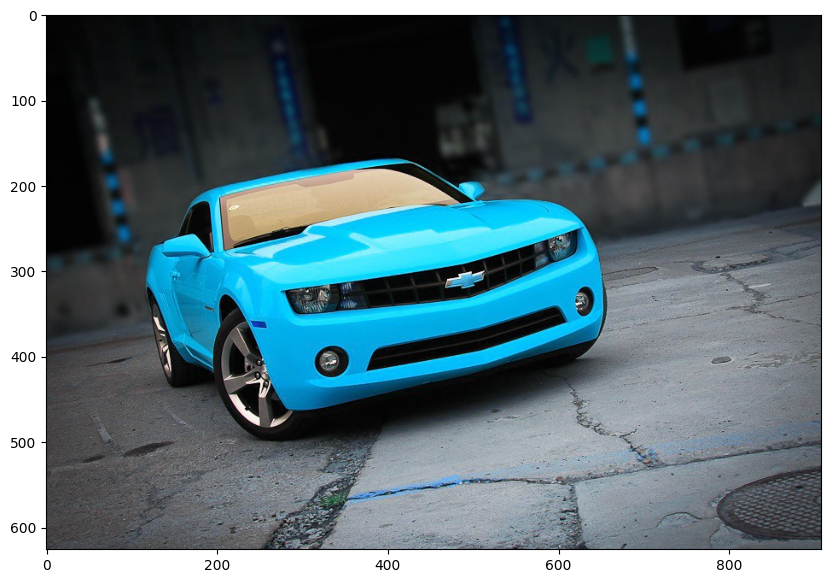

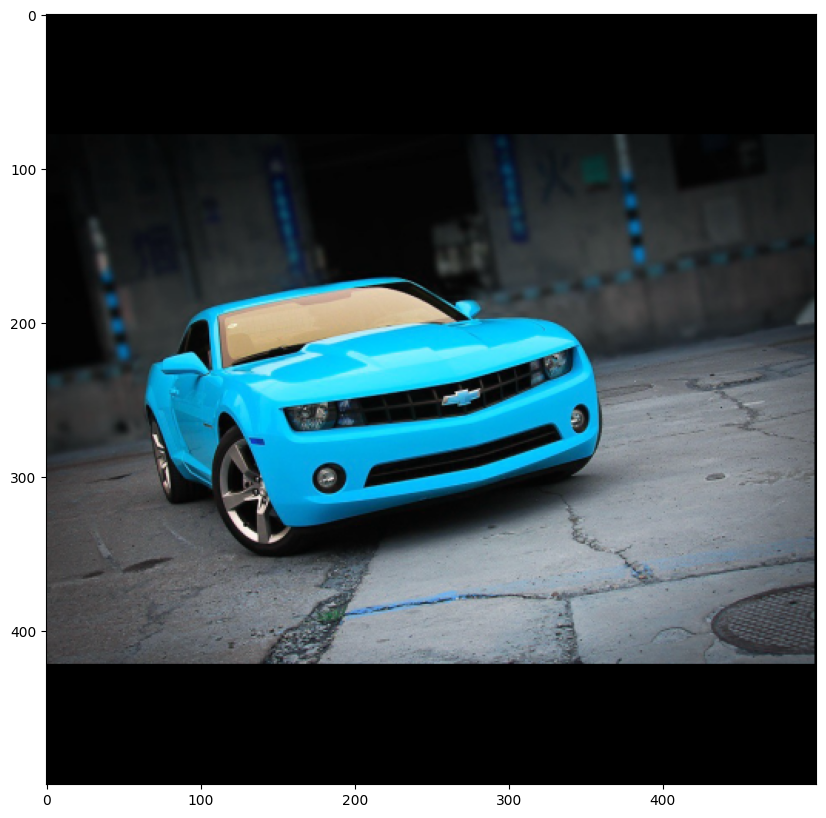

In [59]:
file_paths = []
for root, dirs, files in os.walk(IMG_DIR):
    for file in files:
        file_paths.append(os.path.join(root, file))
random_file = random.choice(file_paths)

img = cv2.imread(random_file)
plt.imshow(img)
plt.show()

padded_image = ResizeAndPad(img, target_size=(500, 500), padding_color=(0, 0, 0),resize=True)
plt.imshow(padded_image)
plt.show()
